In [27]:
import tensorflow as tf
from tensorflow.python.ops import control_flow_ops
import os, os.path
import sys
sys.path.insert(0,'../processing/')
sys.path.insert(0,'../')
from datasets import sythtextprovider
from nets import txtbox_300, textbox_common, np_methods
#from processing import image_processing
from image_processing2 import *
from processing import ssd_vgg_preprocessing, visualization,txt_preprocessing
import tf_utils
import time
slim = tf.contrib.slim
import load_batch
import numpy as np

In [3]:
#isess = tf.InteractiveSession()

text_shape (300, 300)
file_path: ../data/sythtext/1.tfrecord


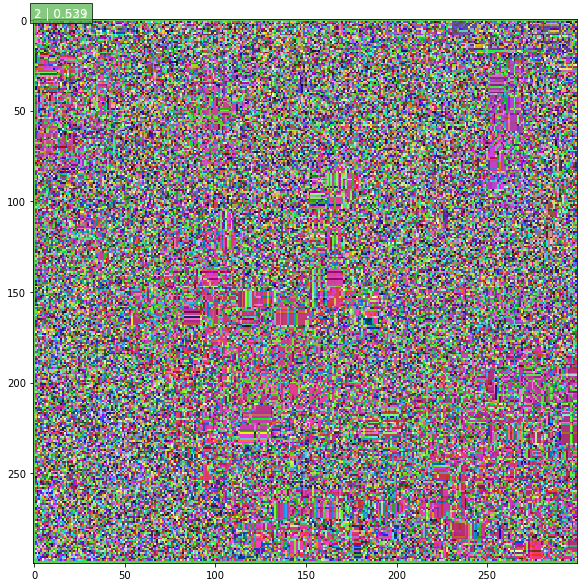

In [43]:
with tf.Graph().as_default(): 
    # build a net
    text_net = txtbox_300.TextboxNet()
    text_shape = text_net.params.img_shape
    print 'text_shape '+  str(text_shape)
    text_anchors = text_net.anchors(text_shape)
    
    ## dataset provider
    dataset = sythtextprovider.get_datasets('../data/sythtext/',file_pattern='1.tfrecord')
    
    data_provider = slim.dataset_data_provider.DatasetDataProvider(
            dataset, common_queue_capacity=32, common_queue_min=2)
    
    [image, shape, glabels, gbboxes,height,width] = \
    data_provider.get(['image', 'shape',
                     'object/label',
                     'object/bbox','height','width'])
    
    image, glabels, gbboxes,num = \
    txt_preprocessing.preprocess_image(image,  glabels,gbboxes, 
                                            text_shape,is_training=True)

    glocalisations, gscores = \
    net.bboxes_encode( gbboxes, anchors, num,match_threshold = 0.5)
    #glocalisations = tf.expand_dims(glocalisations, axis=0)
    #gscores = tf.expand_dims(gscores, axis=0)
    
    with tf.Session() as sess: 
        sess.run(tf.global_variables_initializer())
        with slim.queues.QueueRunners(sess):
            for i in xrange(1):
                rpredictions, rlocalisations, img = sess.run([gscores, glocalisations,image])
                rclasses, rscores, rbboxes = np_methods.ssd_bboxes_select(
                        rpredictions, rlocalisations, text_anchors,
                        select_threshold=0.5, img_shape=text_shape, num_classes=2, decode=True)

                rbboxes = np_methods.bboxes_clip(rbboxes)
                rclasses, rscores, rbboxes = np_methods.bboxes_sort(rclasses, rscores, rbboxes, top_k=400)
                rclasses, rscores, rbboxes = np_methods.bboxes_nms(rclasses, rscores, rbboxes, 
                                                                   nms_threshold=0.45)
                # Resize bboxes to original image shape. Note: useless for Resize.WARP!
                visualization.plt_bboxes(img, rclasses, rscores, rbboxes)

In [40]:
rbboxes

array([], shape=(0, 4), dtype=float32)

In [44]:
print rlocalisations[0].shape
print rpredictions[0].shape
for i in range(6):
    print rlocalisations[i][np.where(rpredictions[i] > 0.5)]
#rlocalisations[np.where()]

(38, 38, 2, 6, 4)
(38, 38, 2, 6)
[]
[]
[]
[]
[[ 1.20639563  0.80169266  2.03736043 -0.11579166]
 [ 0.85305059  1.13376462  0.30449226  1.61707628]
 [ 0.69651288  1.38857245 -0.70917022  2.63073897]
 [ 1.20639563 -1.39128983  2.03736043 -0.11579166]
 [ 0.85305059 -1.96758103  0.30449226  1.61707628]
 [ 0.69651288 -2.40978456 -0.70917022  2.63073897]
 [-3.17956901  0.80169266  2.03736043 -0.11579166]]
[]


In [47]:
np.where(rpredictions[0] >0.5)

(array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64))